## Implement Deep Convolutional GAN

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Discriminator

In [3]:
def discriminator(x_image, reuse = False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    
    return d4

### Generator
It starts by creating a batch of random noise from the latente space $z$, then passes it through a handful of convolutions to produce a 28 x 28 image.

In [4]:
def generator(batch_size, z_dim):
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    return g4

### Set parameter

In [5]:
batch_size = 50
z_dimensions = 100

### Define loss

In [6]:
x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder')
Gz = generator(batch_size, z_dimensions)
Dx = discriminator(x_placeholder)
Dg = discriminator(Gz, reuse=True)

In [7]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [8]:
tvar = tf.trainable_variables()

d_vars = [var for var in tvar if 'd_' in var.name]
g_vars = [var for var in tvar if 'g_' in var.name]

### Define train_op

In [9]:
with tf.variable_scope(tf.get_variable_scope(), reuse = False) as scope:
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

pass helpful summary scalars and sample images to TensorBoard

In [10]:
with tf.Session() as sess:
#Outputs a Summary protocol buffer containing a single scalar value.
    tf.summary.scalar('Generator_loss', g_loss)
    tf.summary.scalar('Discriminator_loss_real', d_loss_real)
    tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

    d_real_count_ph = tf.placeholder(tf.float32)
    d_fake_count_ph = tf.placeholder(tf.float32)
    g_count_ph = tf.placeholder(tf.float32)

    tf.summary.scalar('d_real_count', d_real_count_ph)
    tf.summary.scalar('d_fake_count', d_fake_count_ph)
    tf.summary.scalar('g_count', g_count_ph)

    # Sanity check to see how the discriminator evaluates
    # generated and real MNIST images
    d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
    d_on_real = tf.reduce_mean(discriminator(x_placeholder))

    tf.summary.scalar('d_on_generated_eval', d_on_generated)
    tf.summary.scalar('d_on_real_eval', d_on_real)

    images_for_tensorboard = generator(batch_size, z_dimensions)
    tf.summary.image('Generated_images', images_for_tensorboard, 10)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/gan/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    print(logdir)

tensorboard/gan/


We want to eventually reach a point where the discriminator correctly classifies nearly all real MNIST images as MNIST images, and classifies generated images as MNIST images about 50% of the time. There are several failure modes that we need to avoid:
* Discriminator losses approach zero: this leaves practically no gradients for the generator's optimizer.
* Discriminator losses rise unbounded on generated images: similarly, this leaves practically no gradient for the discriminator to improve, and the generator's training stalls, too, since the gradients it's reading suggest that it has achieved perfect performance.
* Divergent discriminator accuracy: the discriminator learns a shortcut by either classifying everything as real or everything as generated. You can detect this by checking the discriminator's losses on generated images against the discriminator's losses on real images.

TRAINING STEP 0 AT 2017-05-31 17:04:35.617374
Discriminator classification [ -6.13864104e-05]


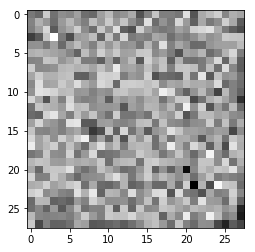

Discriminator classification [ -9.57251468e-05]


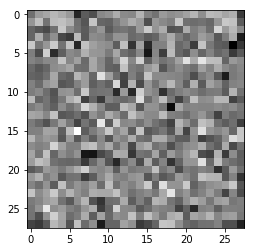

Discriminator classification [ -7.35184585e-05]


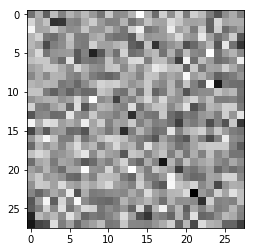

saved to models/pretrained_gan.ckpt-0


In [ ]:
with tf.Session() as sess:
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())

    #During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
    #For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
    #to obtain a probability score (this is the Dg variable we specified earlier).
    #As we remember from our loss function, the cross entropy loss gets minimized, 
    #and only the generator’s weights and biases get updated.
    #We'll do the same for the discriminator update. We’ll be taking a batch of images 
    #from the mnist variable we created way at the beginning of our program.
    #These will serve as the positive examples, while the images in the previous section are the negative ones.

    gLoss = 0
    dLossFake, dLossReal = 1, 1
    d_real_count, d_fake_count, g_count = 0, 0, 0
    for i in range(50000):
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        if dLossFake > 0.6:
            # Train discriminator on generated images
            _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                        {x_placeholder: real_image_batch})
            d_fake_count += 1

        if gLoss > 0.5:
            # Train the generator
            _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                        {x_placeholder: real_image_batch})
            g_count += 1

        if dLossReal > 0.45:
            # If the discriminator classifies real images as fake,
            # train discriminator on real values
            _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                        {x_placeholder: real_image_batch})
            d_real_count += 1

        if i % 10 == 0:
            real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
            summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                        d_fake_count_ph: d_fake_count, g_count_ph: g_count})
            writer.add_summary(summary, i)
            d_real_count, d_fake_count, g_count = 0, 0, 0

        if i % 1000 == 0:
            # Periodically display a sample image in the notebook
            # (These are also being sent to TensorBoard every 10 iterations)
            images = sess.run(generator(3, z_dimensions))
            d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
            print("TRAINING STEP", i, "AT", datetime.datetime.now())
            for j in range(3):
                print("Discriminator classification", d_result[j])
                im = images[j, :, :, 0]
                plt.imshow(im.reshape([28, 28]), cmap='Greys')
                plt.show()

        if i % 5000 == 0:
            save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
            print("saved to %s" % save_path)